In [1]:
from rotorcraft import ConventionalRotorcraft, CoaxialRotorcraft, TiltRotorcraft
from mission_design import FlightMissionScenario, DesignConstraints, DesignAssumptions
import matplotlib.pyplot as plt
import numpy as np
import csv

## Mission setup

In [8]:
# don't really need hover apart from identification of sampling/landing locations
# 3 minutes used in consideration of this and additional redundancy around takeoff/landing
mission_scenario = FlightMissionScenario(
        hover_time=3*60, forward_flight_distance=600, climb_height=50, 
        climb_rate=10, descent_rate=10)
MASS_LIMIT = 50
design_constraints = DesignConstraints(mass_limit=MASS_LIMIT, max_diameter=4.35)
design_assumptions = DesignAssumptions()

## Create aircraft

In [9]:
# design_constraints.MAX_DIAMETER = 1000

coaxial = CoaxialRotorcraft("Coaxial - Ingenuity-like", 2, 4, mission_scenario, design_constraints, design_assumptions)
quad = ConventionalRotorcraft("Quadcopter", 4, 4, mission_scenario, design_constraints, design_assumptions)
hex = ConventionalRotorcraft("Hexcopter", 6, 4, mission_scenario, design_constraints, design_assumptions)
octo = ConventionalRotorcraft("Octocopter", 8, 4, mission_scenario, design_constraints, design_assumptions)
quad_coaxial = CoaxialRotorcraft("Quad coaxial", 8, 4, mission_scenario, design_constraints, design_assumptions)
tiltrotor = TiltRotorcraft("Hex-tiltrotor", 6, 4, 4, mission_scenario, design_constraints, design_assumptions)
aircrafts = [coaxial, quad, hex, octo, quad_coaxial, tiltrotor]

### If want to write to csv

In [10]:
design_masses = [20, 25, 30, 35, 40, 45, 50]
with open("data.csv", "w", newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    header_str = "aircraft,no_rotors,no_nontilting_rotors,no_blades,max_thrust_requirement,rotor_radius,max_thrust_power,hover_power,f_flight_power,motor_rpm_hover,motor_power,motor_power_spec,motor_torque,max_forward_velocity,total_energy,flight_energy,ground_energy,sampling_energy,sleep_energy,design_mass,contingency_mass,motor_mass,battery_mass,solar_panel_mass,rotor_mass,structure_mass,ground_mobility_mass,flight_elec_mass,total_empty_mass,payload"
    header = header_str.split(',')
    csv_writer.writerow(header)
    for aircraft in aircrafts:
        for design_mass in design_masses:
            aircraft.calc_and_verify_initial_design(design_mass)
            csv_writer.writerow(aircraft.get_csv_summary())


Coaxial - Ingenuity-like
-----
New analysis: calculation and verification of initial design
-----

Design mass of rotorcraft is: 20.00kg
Maximum thrust required is: 111.30N
Rotor radius required to produce maximum thrust is 1.13m
Max thrust power calculations:
Induced power per rotor is 715.72W, profile power per rotor is 267.64W
Power required for maximum thrust is: 2892.24W
Motor rotational speed at hover: 1574.09RPM
Power required from the motors at max thrust is: 2892.24W
Hover power calculations:
Induced power per rotor is 715.72W, profile power per rotor is 145.68W
Motor is specced to: 3800.32W (150% hover power)
Maximum torque required at maximum thrust is: 17.55N.m
Maximum forward velocity of aircraft is: 66.52m/s
----
Energy calculations
----
Forward velocity used for mission: 30.00m/s
Hover power calculations:
Induced power per rotor is 715.72W, profile power per rotor is 145.68W
Forward flight power calculations
Induced power per rotor is 1096.62W, profile power per rotor i

ValueError: Cannot create required thrust to fit in aeroshell. Rotor radius: 0.98 results in diameter 4.73m aeroshell diameter: 4.35

## Perform analyses

### Initial verification

In [11]:
design_mass = 20
for aircraft in aircrafts:
    payload = aircraft.calc_and_verify_initial_design(design_mass)


Coaxial - Ingenuity-like
-----
New analysis: calculation and verification of initial design
-----

Design mass of rotorcraft is: 20.00kg
Maximum thrust required is: 111.30N
Rotor radius required to produce maximum thrust is 1.13m
Max thrust power calculations:
Induced power per rotor is 715.72W, profile power per rotor is 267.64W
Power required for maximum thrust is: 2892.24W
Motor rotational speed at hover: 1574.09RPM
Power required from the motors at max thrust is: 2892.24W
Hover power calculations:
Induced power per rotor is 715.72W, profile power per rotor is 145.68W
Motor is specced to: 3800.32W (150% hover power)
Maximum torque required at maximum thrust is: 17.55N.m
Maximum forward velocity of aircraft is: 66.52m/s
----
Energy calculations
----
Forward velocity used for mission: 30.00m/s
Hover power calculations:
Induced power per rotor is 715.72W, profile power per rotor is 145.68W
Forward flight power calculations
Induced power per rotor is 1096.62W, profile power per rotor i

ValueError: Cannot create required thrust to fit in aeroshell. Rotor radius: 0.80 results in diameter 4.80m aeroshell diameter: 4.35

### Payload efficiency tradeoff

Vary design_mass and calculate payload/design_mass


Coaxial - Ingenuity-like
-----
New analysis: calculation and verification of initial design
-----

Design mass of rotorcraft is: 10.00kg
Maximum thrust required is: 55.65N
Rotor radius required to produce maximum thrust is 0.80m
Max thrust power calculations:
Induced power per rotor is 357.86W, profile power per rotor is 133.82W
Power required for maximum thrust is: 1446.12W
Motor rotational speed at hover: 2226.10RPM
Power required from the motors at max thrust is: 1446.12W
Hover power calculations:
Induced power per rotor is 357.86W, profile power per rotor is 72.84W
Motor is specced to: 1900.16W (150% hover power)
Maximum torque required at maximum thrust is: 6.20N.m
Maximum forward velocity of aircraft is: 66.52m/s
----
Energy calculations
----
Forward velocity used for mission: 30.00m/s
Hover power calculations:
Induced power per rotor is 357.86W, profile power per rotor is 72.84W
Forward flight power calculations
Induced power per rotor is 548.31W, profile power per rotor is 224

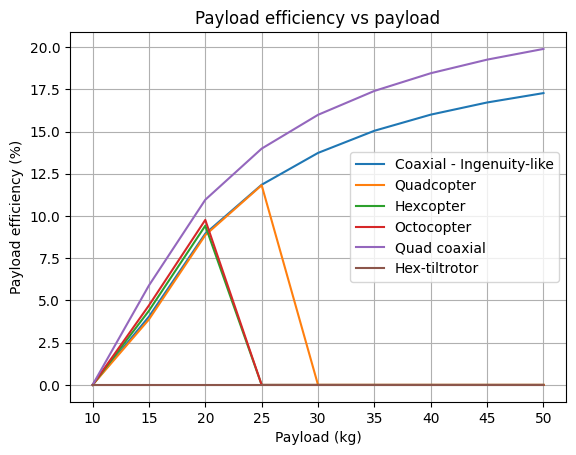

In [12]:
plt.figure()
for aircraft in aircrafts:
    design_masses, payload_efficiences = aircraft.payload_efficiency_analysis()
    plt.plot(design_masses, np.array(payload_efficiences)*100, label=aircraft.name)
plt.title(f"Payload efficiency vs payload")
plt.xlabel("Payload (kg)")
plt.ylabel("Payload efficiency (%)")
plt.grid(True)
plt.legend()
plt.show()

### Payload vs hover/range benefits tradeoff

- fix design_mass (maybe at MASS_LIMIT, maybe at maximum payload efficiency) 
- decrease the proportion of payload for sampling and move into battery to provide more energy/power
- back calculate HOVER_TIME or FORWARD_FLIGHT_RANGE from total_power

Assumption:
- for the purpose of this ignoring the climb/descent power

Purpose:
- helpful to explore how incorrect assumption of lander accuracy could be overcome


Coaxial - Ingenuity-like
-----
New analysis: calculation and verification of initial design
-----

Design mass of rotorcraft is: 50.00kg
Maximum thrust required is: 278.25N
Rotor radius required to produce maximum thrust is 1.79m
Max thrust power calculations:
Induced power per rotor is 1789.30W, profile power per rotor is 669.10W
Power required for maximum thrust is: 7230.60W
Motor rotational speed at hover: 995.54RPM
Power required from the motors at max thrust is: 7230.60W
Hover power calculations:
Induced power per rotor is 1789.30W, profile power per rotor is 364.21W
Motor is specced to: 9500.80W (150% hover power)
Maximum torque required at maximum thrust is: 69.36N.m
Maximum forward velocity of aircraft is: 66.52m/s
----
Energy calculations
----
Forward velocity used for mission: 30.00m/s
Hover power calculations:
Induced power per rotor is 1789.30W, profile power per rotor is 364.21W
Forward flight power calculations
Induced power per rotor is 2741.55W, profile power per rotor

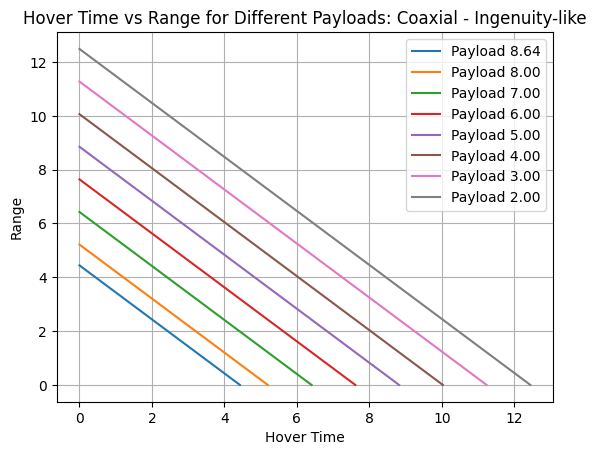

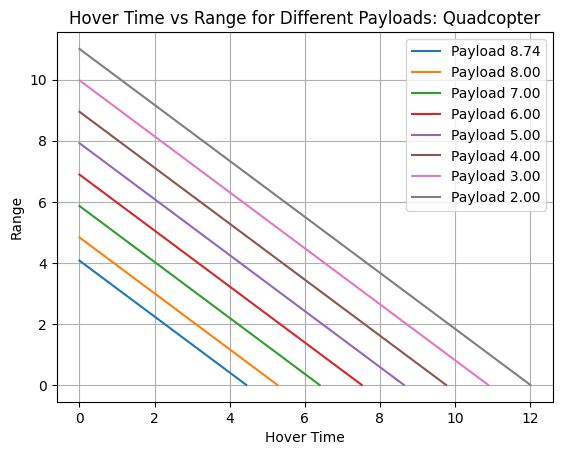

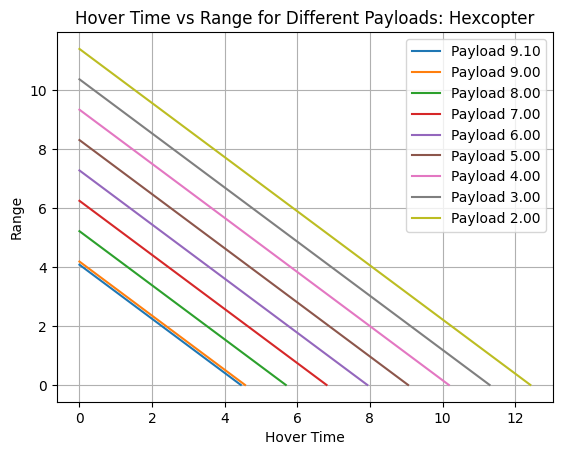

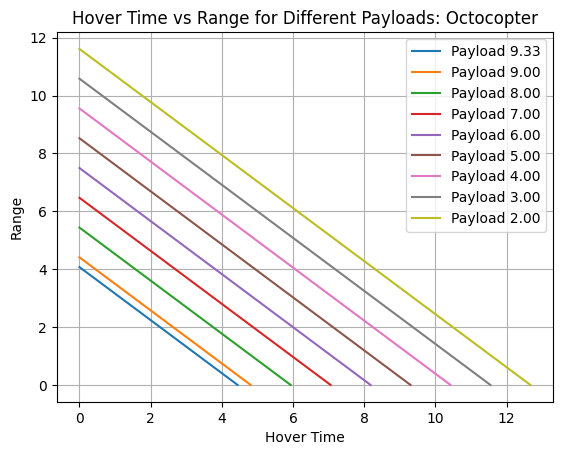

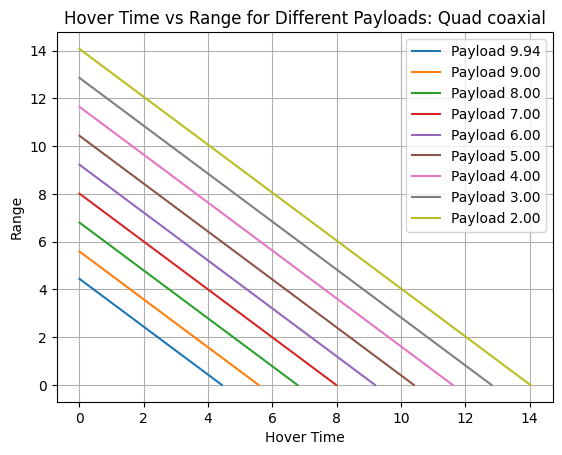

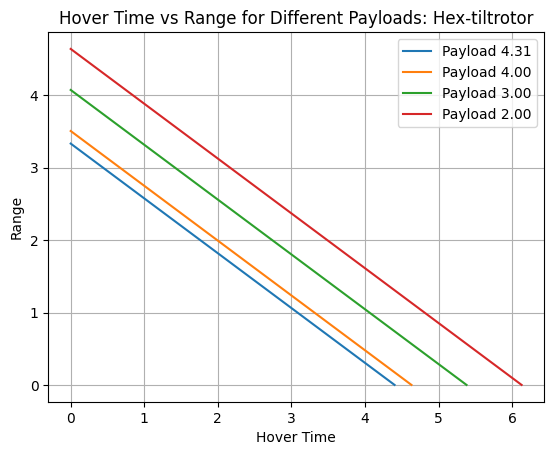

In [7]:
for aircraft in aircrafts:
    MIN_PAYLOAD = 2
    valid_payloads, hover_times, ranges = aircraft.trade_payload_for_battery(design_mass, MIN_PAYLOAD)

    mass_max_payload_efficiency = design_masses[np.argmax(payload_efficiences)]
    valid_payloads, hover_times, ranges = aircraft.trade_payload_for_battery(mass_max_payload_efficiency, MIN_PAYLOAD)

    plt.figure()
    for payload, rng, hover_time in zip(valid_payloads, ranges, hover_times):
        plt.plot([0, hover_time/60], [rng/1000, 0], label=f"Payload {payload:.2f}")
    plt.xlabel('Hover Time')
    plt.ylabel('Range')
    plt.title(f'Hover Time vs Range for Different Payloads: {aircraft.name}')
    plt.legend()
    plt.grid(True) 
plt.show()

    